## Sentiment Analysis
<br>
NLP and Data Preprocessing
<br>
Balanced vs Unbalanced Data Analysis
<br>
Sentiment Analysis Creation
<br>
Testing Accuracy
<br>
Vader Accuracy Comparison

In [1]:
#importing libraries needed
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sea
%matplotlib inline

In [2]:
original_df = pd.read_csv("Tweets.csv")

In [3]:
df = original_df[['text','airline_sentiment']]
df.head(10)

,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials t...,positive
2,@VirginAmerica I didn't today... Must mean I n...,neutral
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative
5,@VirginAmerica seriously would pay $30 a fligh...,negative
6,"@VirginAmerica yes, nearly every time I fly VX...",positive
7,@VirginAmerica Really missed a prime opportuni...,neutral
8,"@virginamerica Well, I didn't…but NOW I DO! :-D",positive
9,"@VirginAmerica it was amazing, and arrived an ...",positive


In [4]:
df.describe()

,text,airline_sentiment
count,14640,14640
unique,14427,3
top,@united thanks,negative
freq,6,9178


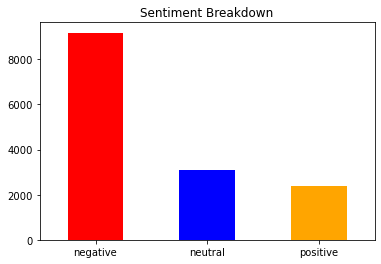

In [5]:
df.airline_sentiment.value_counts().plot(kind='bar',color= ['red','blue','orange'])
plt.title("Sentiment Breakdown")
plt.xticks(rotation=0)
plt.show()

We don't really care for neutral data, as it isn't as helpful as positive or negative, so we'll eliminate that data for now and focus on making a binary classifier.

In [6]:
df = df[df['airline_sentiment'] != 'neutral']
df["airline_sentiment"].value_counts()

negative    9178
positive    2363
Name: airline_sentiment, dtype: int64

#### Here we can see that our data doesn't seem very balanced, which we can confirm with the bar graph above as well. Thus we will try to find a successful way to change this. First, we will simply use the original data to build a classifer, but then we will see what happens when we try to undersample the negative sentiments. This is done to avoid any overfitting that might occur from oversampling the positive sentimments to compensate instead. Undersampling the negative sentiments should be fine given the amount of data we have, but we can test the accuracies at the end to see if it improves our original classifier and by how much.

In [8]:
#SPLITTING THE DATA UP FOR FUTURE TRAILS
df_for_under = df.copy(deep=False)
df_vader = df.copy(deep=False)

### Part 1: Original Data

In [9]:
#Converting our categorical data to numerical data we can use to classify using factorization
sent_factor = df.airline_sentiment.factorize()

In [10]:
#extract text data to tokenize
tweets = df.text.values
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(tweets)
vocab_size = len(tokenizer.word_index) + 1
encoded_docs = tokenizer.texts_to_sequences(tweets)

In [11]:
#pad sentences to have uniform length
from tensorflow.keras.preprocessing.sequence import pad_sequences
padded_sequence = pad_sequences(encoded_docs, maxlen=200)

In [12]:
#Running LSTM Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense, Dropout, SpatialDropout1D
from tensorflow.keras.layers import Embedding
embedding_vector_length = 32
model = Sequential()
model.add(Embedding(vocab_size, embedding_vector_length, input_length=200))
model.add(SpatialDropout1D(0.25))
model.add(LSTM(50, dropout=0.5, recurrent_dropout=0.5))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])

In [13]:
#checking model
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 32)           423488    
                                                                 
 spatial_dropout1d (SpatialD  (None, 200, 32)          0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 50)                16600     
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 440,139
Trainable params: 440,139
Non-trainable params: 0
__________________________________________________

#### Explain model

In [14]:
#Training the model
model_history = model.fit(padded_sequence,sent_factor[0],validation_split=0.2, epochs=5, batch_size=32)

Epoch 1/5
289/289 [==============================] - 42s 139ms/step - loss: 0.3870 - accuracy: 0.8400 - val_loss: 0.2269 - val_accuracy: 0.9043
Epoch 2/5
289/289 [==============================] - 39s 136ms/step - loss: 0.2145 - accuracy: 0.9170 - val_loss: 0.1628 - val_accuracy: 0.9437
Epoch 3/5
289/289 [==============================] - 42s 144ms/step - loss: 0.1637 - accuracy: 0.9401 - val_loss: 0.1629 - val_accuracy: 0.9394
Epoch 4/5
289/289 [==============================] - 47s 162ms/step - loss: 0.1443 - accuracy: 0.9472 - val_loss: 0.1698 - val_accuracy: 0.9402
Epoch 5/5
289/289 [==============================] - 44s 152ms/step - loss: 0.1182 - accuracy: 0.9575 - val_loss: 0.1827 - val_accuracy: 0.9407


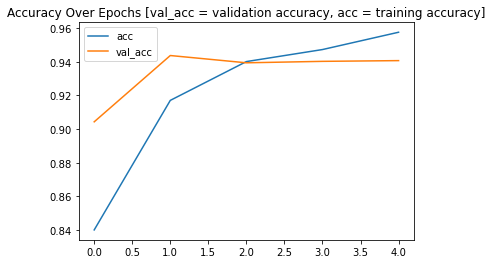

In [16]:
import matplotlib.pyplot as plt
plt.plot(model_history.history['accuracy'], label='acc')
plt.plot(model_history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.title("Accuracy Over Epochs [val_acc = validation accuracy, acc = training accuracy]")
plt.show()

Our model is quite accurate! It reached 94% accuracy over 5 epochs, a relatively short amount of time.

## Part II: Undersampling Negative Sentiments

In [17]:
#undersampling function
def undersample(df:pd.DataFrame, label_col_name:str) -> pd.DataFrame:
    # find the number of positive sentiments
    min = df[label_col_name].value_counts().min()
    return (df
            # split the dataframe by sentiment type
            .groupby(label_col_name)
            # sample min
            .apply(lambda x: x.sample(min))
            # recombine the dataframes into one
            .reset_index(drop=True)
            )

In [18]:
df_for_under = undersample(df_for_under, 'airline_sentiment')

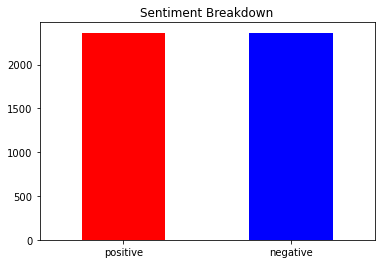

positive    2363
negative    2363
Name: airline_sentiment, dtype: int64

In [19]:
#check to see new dataframe
df_for_under.airline_sentiment.value_counts().plot(kind='bar',color= ['red','blue'])
plt.title("Sentiment Breakdown")
plt.xticks(rotation=0)
plt.show()
df_for_under["airline_sentiment"].value_counts()

In [20]:
#redo the process like we did for the previous dataframe
sent_factor_under = df_for_under.airline_sentiment.factorize()
tweets_for_under = df_for_under.text.values
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(tweets_for_under)
vocab_size = len(tokenizer.word_index) + 1
encoded_docs = tokenizer.texts_to_sequences(tweets_for_under)
padded_sequence_under = pad_sequences(encoded_docs, maxlen=200)
embedding_vector_length = 32
under_model = Sequential()
under_model.add(Embedding(vocab_size, embedding_vector_length, input_length=200))
under_model.add(SpatialDropout1D(0.25))
under_model.add(LSTM(50, dropout=0.5, recurrent_dropout=0.5))
under_model.add(Dropout(0.2))
under_model.add(Dense(1, activation='sigmoid'))
under_model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])
under_model_history = model.fit(padded_sequence_under,sent_factor_under[0],validation_split=0.2, epochs=5, batch_size=32)

Epoch 1/5
119/119 [==============================] - 18s 151ms/step - loss: 0.7151 - accuracy: 0.6558 - val_loss: 0.8283 - val_accuracy: 0.4968
Epoch 2/5
119/119 [==============================] - 30s 250ms/step - loss: 0.4416 - accuracy: 0.8016 - val_loss: 0.5482 - val_accuracy: 0.7854
Epoch 3/5
119/119 [==============================] - 27s 229ms/step - loss: 0.3177 - accuracy: 0.8741 - val_loss: 0.6240 - val_accuracy: 0.7463
Epoch 4/5
119/119 [==============================] - 26s 214ms/step - loss: 0.2214 - accuracy: 0.9164 - val_loss: 0.5520 - val_accuracy: 0.7992
Epoch 5/5
119/119 [==============================] - 27s 226ms/step - loss: 0.1868 - accuracy: 0.9325 - val_loss: 0.3422 - val_accuracy: 0.8753


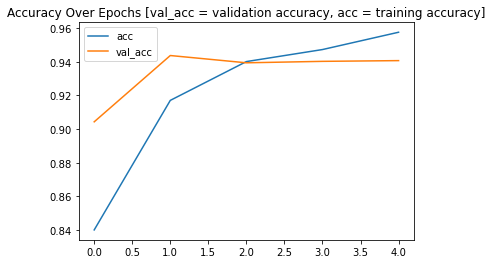

In [27]:
plt.plot(model_history.history['accuracy'], label='acc')
plt.plot(model_history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.title("Accuracy Over Epochs [val_acc = validation accuracy, acc = training accuracy]")
plt.show()

Here we see that there can be averse affects to undersampling, as we lose key information. Therefore, we will keep our original model for binary classification as it is slightly more accurate

### Part III: Vader

In [22]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
sentiment = SentimentIntensityAnalyzer()

In [23]:
#Vader Function
def sentiment_scores(sentence):
    sentiment_dict = sentiment.polarity_scores(sentence)
    if sentiment_dict['compound'] >= 0.05 :
        return "positive"
    elif sentiment_dict['compound'] <= - 0.05 :
        return "negative"
    else :
        return "neutral"

In [24]:
#Vader Accuracy
total = 0
num_correct = 0
for ind in df_vader.index:
    total += 1
    vader_says = sentiment_scores(df_vader['text'][ind])
    if vader_says == (df_vader['airline_sentiment'][ind]):
        num_correct +=1
print('Vader Accuracy: ')
print(num_correct/total*100)
print("percent")

Vader Accuracy: 
53.574213672991945
percent


In [25]:
#Vader Function (slightly modified)
def sentiment_scores2(sentence):
    sentiment_dict = sentiment.polarity_scores(sentence)
    if sentiment_dict['compound'] >= 0.00 :
        return "positive"
    elif sentiment_dict['compound'] <= - 0.00 :
        return "negative"
    else :
        return "neutral"

In [26]:
#Vader Accuracy
total = 0
num_correct = 0
for ind in df_vader.index:
    total += 1
    vader_says = sentiment_scores2(df_vader['text'][ind])
    if vader_says == (df_vader['airline_sentiment'][ind]):
        num_correct +=1
print('Vader Accuracy: ')
print(num_correct/total*100)
print("percent")

Vader Accuracy: 
55.60176761112555
percent


### Our sentimental analyzer is far better! This makes sense as it is far more personalized for this purpose than Vader is. Words like "United" might be messing with the Vader Sentiment Analyzer while our model knows enough to work around these words.

### Part III: Just For Fun

In [28]:
#creating a prediction functions using our model
def predict_sentiment(text):
    tweet = tokenizer.texts_to_sequences([text])
    tweet = pad_sequences(tw,maxlen=200)
    prediction = int(model.predict(tw).round().item())
    print("Predicted label: ", sent_factor[1][prediction])

In [46]:
predict_sentiment("I am enraged by this service!")
predict_sentiment("I enjoyed my journey on this flight.")

Predicted label:  negative
Predicted label:  positive


One reason I wanted to test this out is to see if our model fell into one of the major pitfalls of having unbalanced data; If 95% of the data is negative, the model could just achieve 95% accuracy by labelling everything as negative. Granted this is an exaggerated unbalanced set example, but the notion of weighing the major class more holds true. Having such little comparative positive data could also lead to overfitting for positive data, which we seemed to have avoided here too.